We want to analyze wether a person from a US adult census is a high or low earner.
The target feature, salary, is given as a string indicating if the individual earns more or less than 50k yearly,
so there isn't much to do in feature selection since we can't analyze relationship between the salary and the features. So we will consider all features as important for modelling,except the fnlgt variable, which with a quick search we can see is a weight that represents how a individual represents a number of people, causing colinearty between the other features,so we will drop it.

In [25]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu, sigmoid
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns


In [26]:
df = pd.read_csv("/Users/fujiemei/Desktop/adult.data.csv")

In [27]:
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


We can see that there are not null values, but we will have to inspect further to see if that are inconsistent data,
which we will soon find out ? values which we will correct replacing them with the highest frequency value of each
column.
We can also see that education_num(number of years of education) and education are highly correlated but don't know
which to delete, we will see below with RF important_features the best one to take out is the education column,
but in the meantime we won't do it and progress further as it is.

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  salary          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [29]:
categorical_data = ["workclass","education","marital-status","occupation",
                    "relationship","race","sex","native-country"]
for categories in  categorical_data:
    print(categories+":")
    print(df[categories].unique())


workclass:
['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' '?'
 'Self-emp-inc' 'Without-pay' 'Never-worked']
education:
['Bachelors' 'HS-grad' '11th' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 'Assoc-voc' '7th-8th' 'Doctorate' 'Prof-school' '5th-6th' '10th'
 '1st-4th' 'Preschool' '12th']
marital-status:
['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Married-AF-spouse' 'Widowed']
occupation:
['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Craft-repair' 'Transport-moving'
 'Farming-fishing' 'Machine-op-inspct' 'Tech-support' '?'
 'Protective-serv' 'Armed-Forces' 'Priv-house-serv']
relationship:
['Not-in-family' 'Husband' 'Wife' 'Own-child' 'Unmarried' 'Other-relative']
race:
['White' 'Black' 'Asian-Pac-Islander' 'Amer-Indian-Eskimo' 'Other']
sex:
['Male' 'Female']
native-country:
['United-States' 'Cuba' 'Jamaica' 'India' '?' 'Mexico' 'South'
 'Puerto-Rico' 'Honduras' 'England' '

In [30]:
categories = ["workclass","occupation","native-country"]
for cat in categories:
    print(cat+":")
    print(df[cat].value_counts())

workclass:
Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64
occupation:
Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
?                    1843
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: occupation, dtype: int64
native-country:
United-States                 29170
Mexico                          643
?                               583
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador             

In [31]:
for cat in categories:
   df[cat] = df[cat].replace("?",df[cat].value_counts().index[0])

In [32]:
df["education"] = df['education'].replace(['11th','9th','7th-8th','5th-6th', '10th','1st-4th', 'Preschool','12th']
                                          ,"NoEducation")

In [33]:
df = pd.get_dummies(df,columns =["salary","sex"],drop_first=True)
y = df["salary_>50K"]
X = pd.get_dummies(df,columns=["workclass","education","occupation","native-country","race","marital-status"
                               ,"relationship"])
X = X.drop(columns=["fnlwgt","salary_>50K"])
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 96 columns):
 #   Column                                     Non-Null Count  Dtype
---  ------                                     --------------  -----
 0   age                                        32561 non-null  int64
 1   education-num                              32561 non-null  int64
 2   capital-gain                               32561 non-null  int64
 3   capital-loss                               32561 non-null  int64
 4   hours-per-week                             32561 non-null  int64
 5   sex_Male                                   32561 non-null  uint8
 6   workclass_Federal-gov                      32561 non-null  uint8
 7   workclass_Local-gov                        32561 non-null  uint8
 8   workclass_Never-worked                     32561 non-null  uint8
 9   workclass_Private                          32561 non-null  uint8
 10  workclass_Self-emp-inc                     325

Now we will make predictions with three model, a NN, logistic regression and random forest to see which is the best
fit.

In [34]:
features = X.columns
X_aux=X.copy()
X = X.to_numpy()
y = y.to_numpy()

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .8)

In [36]:
model = Sequential([
    tf.keras.Input(shape=(96,)),
    Dense(20,activation="relu"),
    Dense(1,activation="sigmoid")
                   
])
model.compile(loss="binary_crossentropy",optimizer=tf.keras.optimizers.Adam(0.001),metrics=["accuracy"])
model.fit(X_train,y_train,epochs=5)

Epoch 1/5
814/814 [==============================] - 2s 2ms/step - loss: 2.0594 - accuracy: 0.8115
Epoch 2/5
814/814 [==============================] - 2s 2ms/step - loss: 0.6537 - accuracy: 0.8306
Epoch 3/5
814/814 [==============================] - 2s 2ms/step - loss: 0.5942 - accuracy: 0.8363
Epoch 4/5
814/814 [==============================] - 2s 2ms/step - loss: 0.4850 - accuracy: 0.8409
Epoch 5/5
814/814 [==============================] - 1s 2ms/step - loss: 0.4501 - accuracy: 0.8398


In [37]:
score = model.evaluate(X_test,y_test)

204/204 [==============================] - 0s 1ms/step - loss: 0.4333 - accuracy: 0.8366


In [38]:
model = LogisticRegression(max_iter=150,solver="newton-cg")
model.fit(X_train, y_train) 
predictions = model.predict(X_test)
rms = mean_squared_error(y_test, predictions, squared=False)
print(f'Accuracy for logisitic model:', model.score(X_test, y_test))
print(f'Root square mean:', rms)  
    

Accuracy for logisitic model: 0.846307385229541
Root square mean: 0.3920364967327138


We can see that training with either a logistic regression model from sklearn is as good as with neural networks

In [39]:
model = RandomForestClassifier(n_estimators=200,criterion="entropy")
model.fit(X_train,y_train)
model.score(X_test,y_test)

0.8453861507753724

We see that all model performs really well, with the most accurate being logistic regression, now we can see with
the RF, which features are more important.
We can see that age, hours worked per week and capital-gain and the number of education are the most important
feautres, doesn't seem odd if you think about it.

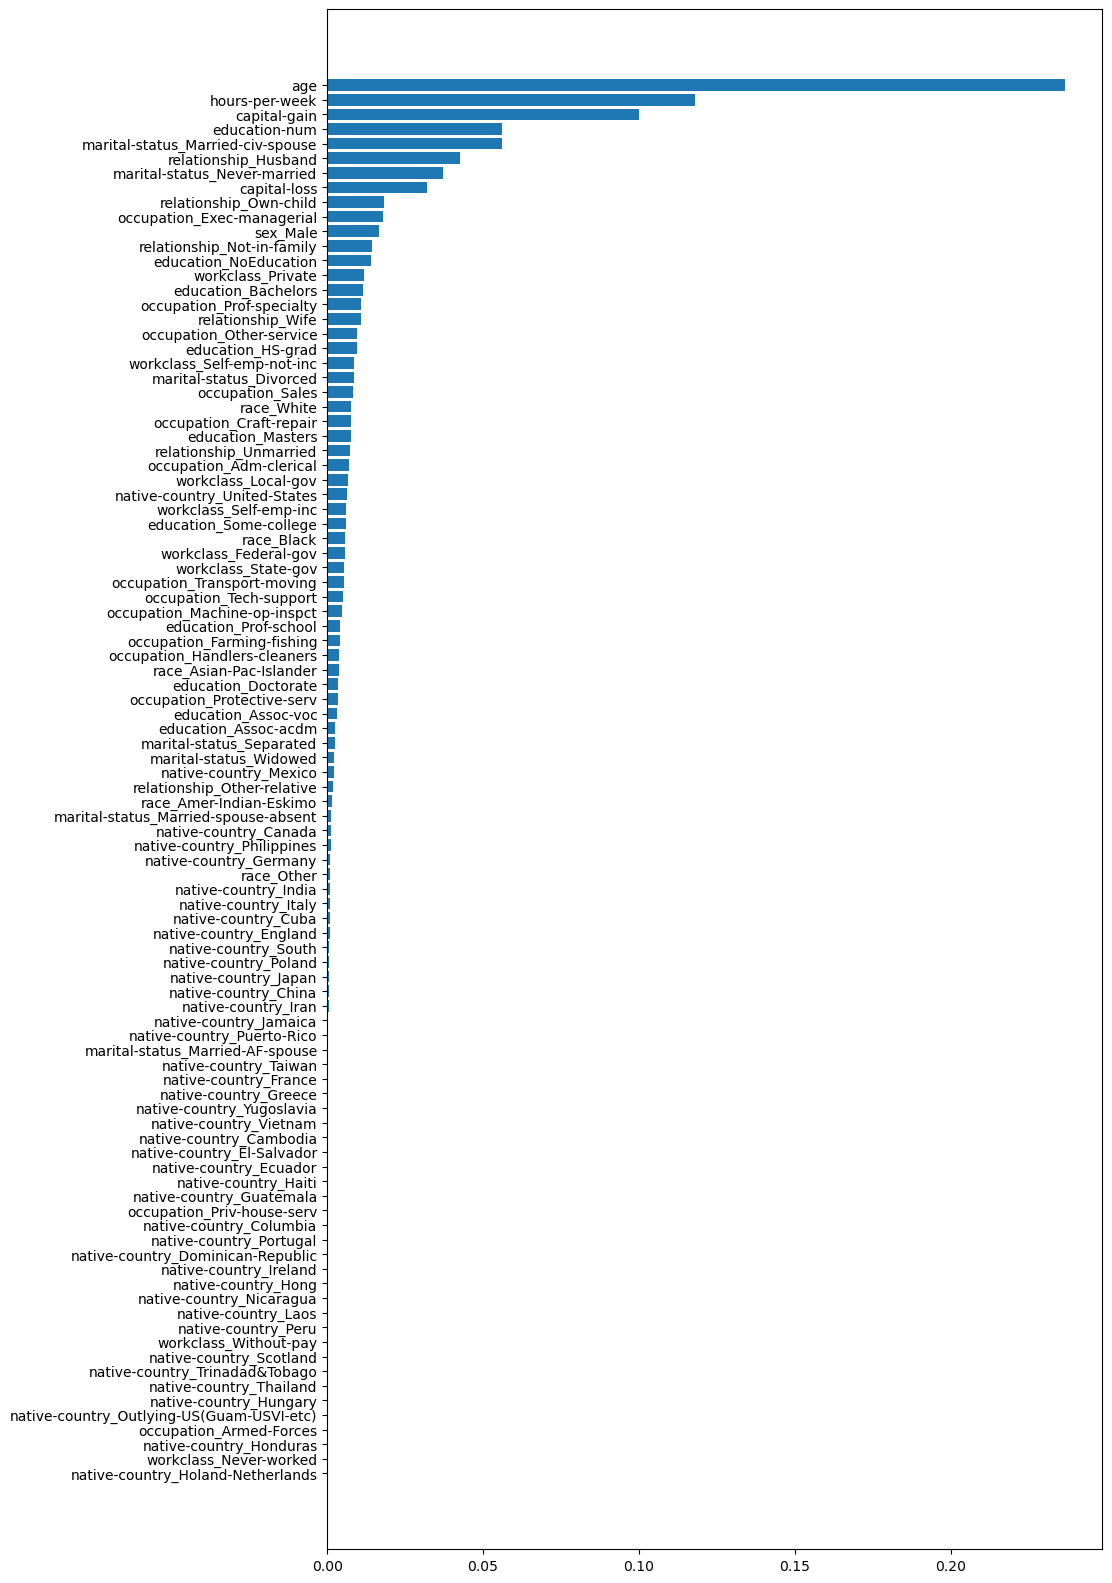

In [40]:
plt.figure(figsize=(10,20))
sorted = model.feature_importances_.argsort()
plt.barh(features[sorted], model.feature_importances_[sorted])
plt.show()